<a href="https://colab.research.google.com/github/head1ton/004_Supervision_Function-using-YOLO/blob/main/estimate_vehicle_speed_with_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!pip install -q supervision ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.9 MB/s eta 0:00:00


In [3]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
download_assets(VideoAssets.VEHICLES)

  0%|          | 0/35345757 [00:00<?, ?it/s]

'vehicles.mp4'

In [5]:
SOURCE_VIDEO_PATH = "vehicles.mp4"
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOULATION = 1280

## Source and Target ROIs

![Source and Target ROIs](https://storage.googleapis.com/com-roboflow-marketing/notebooks/speed-estimation-perspective-1.png)

In [6]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [7]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

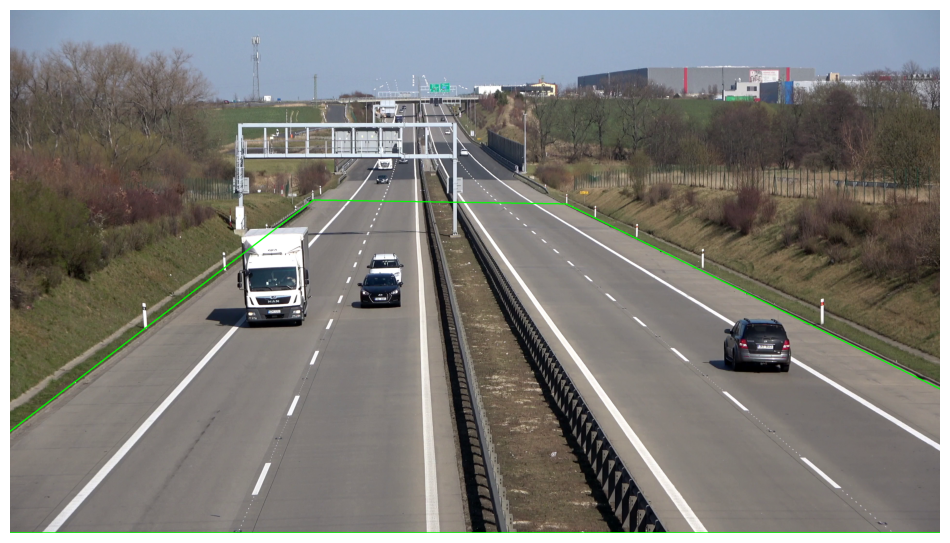

In [9]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.GREEN, thickness=4)
sv.plot_image(annotated_frame)

### Transform Perspective

In [10]:
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.matrix = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.matrix)
        return transformed_points.reshape(-1, 2)

In [11]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

### Process Video

In [16]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

byte_track = sv.ByteTrack(frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD)

thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)

box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=thickness, text_position=sv.Position.BOTTOM_CENTER)

trace_annotator = sv.TraceAnnotator(thickness=thickness, trace_length=video_info.fps * 2, position=sv.Position.BOTTOM_CENTER)

polygon_zone = sv.PolygonZone(polygon=SOURCE)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame, imgsz=MODEL_RESOULATION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        detections = detections[polygon_zone.trigger(detections)]

        detections = detections.with_nms(threshold=IOU_THRESHOLD)
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        points = view_transformer.transform_points(points=points).astype(int)

        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
        sink.write_frame(annotated_frame)